**Functional Autoencoder (FAE):** 

https://github.com/CedricBeaulac/FAE/tree/main

In [ ]:
# Import modules
import torch
import torch.nn.init as init
import torch.nn.functional as F
import torch.nn as nn
from torch import optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image
import pandas as pd
import numpy as np
from numpy import *
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import skfda as fda
from skfda import representation as representation
from skfda.exploratory.visualization import FPCAPlot
import scipy
from scipy import stats
from scipy.interpolate import BSpline
import ignite
import os
import sklearn
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import random
from random import seed
import statistics
from statistics import stdev
from datetime import datetime
import matplotlib.ticker as mtick
from random import seed
import random

# Import functions
import os
import sys
from pathlib import Path
project_dir = Path(r"D:\Mobina\Marquette\FAE Codes")
os.chdir(project_dir)
if str(project_dir) not in sys.path:
    sys.path.insert(0, str(project_dir))

import Functions
from Functions import *

In [ ]:
# Read_ElNino_Data.py file for reading the data 
"""
This script contains the code for importing and pre-processing the simulation data sets
in the manuscript "Functional Autoencoder for Smoothing and Representation Learning".

@author: Sidi Wu
"""

import pandas as pd
import numpy as np
import os
import torch

os.chdir(r"D:\Mobina\Marquette\FAE Codes")

#####################################
### Real application: ElNino data set
#####################################
# Import dataset
x_raw = pd.read_csv('Dataset/ElNino_ERSST.csv')
tpts_raw = pd.read_csv('Dataset/ElNino_ERSST_tpts.csv')
label_table = pd.read_csv('Dataset/ElNino_ERSST_label.csv')
label = label_table.x.to_numpy()
time_grid = np.array(tpts_raw).flatten()

# Pre-process Data sets
# Prepare numpy/tensor data
x_np = np.array(x_raw).astype(float)
x = torch.tensor(x_np).float()
x_mean = torch.mean(x,0)
x = x - torch.mean(x,0)

# Rescale timestamp to [0,1]
tpts_np = np.array(tpts_raw)
tpts_rescale = (tpts_np - min(tpts_np)) / np.ptp(tpts_np)
tpts = torch.tensor(np.array(tpts_rescale))
n_tpts = len(tpts)


In [3]:
###################################################################
# Define the vanilla FAE architecture for regularly functional data
# Create FAE Class
###################################################################
# Below are the settings for the creating the linear FAE (adjust the architecure for nonlinear FAE)
class FAE_vanilla(nn.Module):
    def __init__(self, weight_std=None):
        super(FAE_vanilla, self).__init__()
        ## Select one of the following options (comment out the other one)
        # Opt 1: Linear FAE with 1 hidden layer
        self.fc1 = nn.Linear(n_basis_project, n_rep, bias=False)
        self.fc3 = nn.Linear(n_rep, n_basis_revert, bias=False)
        self.activation = nn.Identity()

        # Opt 2: Nonlinear FAE with 3 hidden layers
        # self.fc1 = nn.Linear(n_basis_project, 100, bias=False)
        # self.fc2 = nn.Linear(100, n_rep, bias=False)
        # self.fc3 = nn.Linear(n_rep, 100, bias=False)
        # self.fc4 = nn.Linear(100, n_basis_revert, bias=False)
        # self.activation = nn.Sigmoid()

        # initialize the weights to a specified, constant value
        if (weight_std is not None):
            for m in self.modules():
                if isinstance(m, nn.Linear):
                    nn.init.normal_(m.weight, mean=0.0, std=weight_std)
                    #nn.init.constant_(m.bias, 0)

    def forward(self, x, tpts, basis_fc_project, basis_fc_revert):
        feature = self.Project(x, tpts, basis_fc_project)

        ## Select one of the following options accordingly (comment out the other one)
        # Opt 1: Linear FAE with 1 hidden layer
        rep = self.activation(self.fc1(feature))
        coef = self.fc3(rep)

        # Opt 2: Nonlinear inear FAE with 3 hidden layers
        # t1 = self.activation(self.fc1(feature))
        # rep = self.fc2(t1)
        # t2 = self.activation(self.fc3(rep))
        # coef = self.fc4(t2)

        x_hat = self.Revert(coef, basis_fc_revert)
        return x_hat, rep, feature, coef

    def Project(self, x, tpts, basis_fc):
        # basis_fc: n_time X nbasis
        # x: n_subject X n_time
        time_diff = tpts[1:] - tpts[:-1]
        W = (torch.cat((torch.tensor([[0]]), time_diff))*1/2 + torch.cat((time_diff, torch.tensor([[0]])))*1/2).flatten().float()
        f = torch.matmul(torch.mul(x, W), torch.t(basis_fc))
        return f

    def Revert(self, x, basis_fc):
        g = torch.matmul(x, basis_fc)
        return g

In [4]:
#####################################
# Define the training procedure
#####################################
# The function for training FAE
def train(train_loader, pen=None, lamb=0):
    model.train()
    train_loss = 0
    score_loss = 0
    for i, data in enumerate(train_loader):
        optimizer.zero_grad()  # The gradients are set to zero
        input = data.to(device)
        out,rep,feature,coef = model(input.float(), tpts, basis_fc_project, basis_fc_revert)
        ## Loss on the score layers (network output layer)
        if shape(feature)==shape(coef):
            score_loss += loss_function(feature, coef) # meaningful when basis functions are orthonormal
        # Penalty term
        penalty = 0
        if pen == "diff":
            delta_c = coef[:,2:] - 2*coef[:,1:-1] + coef[:,:-2]
            penalty = torch.mean(torch.sum(delta_c**2, dim=1))
        # Loss for back-propagation
        loss = loss_function(out, input.float()) + lamb*penalty
        loss.backward()  # The gradient is computed and stored.
        optimizer.step()  # Performs parameter update
        train_loss += loss
    return train_loss, score_loss

# The function for predicting observations with trained FAE
def pred(model, data):
    model.eval()
    input = data.to(device)
    output, rep, feature, coef = model(input.float(), tpts, basis_fc_project, basis_fc_revert)
    loss = loss_function(output, input.float())
    return output, rep, loss, coef # score_loss # we comment out score_loss here because it is meaningless in our implementation


In [8]:
#####################################
# Perform FAE (Model Training)
#####################################
# Below are the settings for the implementation with ElNino data described in the real application section
niter = 1
seed(743)
import random
niter_seed = random.sample(range(5000), niter)
# niter = 10
# seed(743)
# niter_seed = random.sample(range(1000), niter)

# Set up basis functions for input functional weights
n_basis_project = 20
basis_type_project = "Bspline"
# Get basis functions evaluated
if basis_type_project == "Bspline":
    bss_project = representation.basis.BSpline(n_basis=n_basis_project, order=4)
elif basis_type_project == "Fourier":
    bss_project = representation.basis.Fourier([min(tpts.numpy().flatten()), max(tpts.numpy().flatten())], n_basis=n_basis_project)
bss_eval_project = bss_project.evaluate(tpts, derivative=0)
basis_fc_project = torch.from_numpy(bss_eval_project[:, :, 0]).float()

# Set up basis functions for output functional weights
n_basis_revert = 20
basis_type_revert = "Bspline"
# Get basis functions evaluated
if basis_type_revert == "Bspline":
    bss_revert = representation.basis.BSpline(n_basis=n_basis_revert, order=4)
elif basis_type_revert == "Fourier":
    bss_revert = representation.basis.Fourier([min(tpts.numpy().flatten()), max(tpts.numpy().flatten())], n_basis=n_basis_revert)
bss_eval_revert = bss_revert.evaluate(tpts, derivative=0)
basis_fc_revert = torch.from_numpy(bss_eval_revert[:, :, 0]).float()


C:\Users\PC\AppData\Local\Temp\ipykernel_8672\24705101.py:18: DeprecationWarning: The BSpline class is deprecated. Use BSplineBasis instead.
  bss_project = representation.basis.BSpline(n_basis=n_basis_project, order=4)
C:\Users\PC\AppData\Local\Temp\ipykernel_8672\24705101.py:21: DeprecationWarning: The method 'evaluate' is deprecated. Please use the normal calling notation on the basis object instead.
  bss_eval_project = bss_project.evaluate(tpts, derivative=0)
C:\Users\PC\AppData\Local\Temp\ipykernel_8672\24705101.py:29: DeprecationWarning: The BSpline class is deprecated. Use BSplineBasis instead.
  bss_revert = representation.basis.BSpline(n_basis=n_basis_revert, order=4)
C:\Users\PC\AppData\Local\Temp\ipykernel_8672\24705101.py:32: DeprecationWarning: The method 'evaluate' is deprecated. Please use the normal calling notation on the basis object instead.
  bss_eval_revert = bss_revert.evaluate(tpts, derivative=0)


In [10]:
bss_eval_project.shape

(20, 12, 1)

In [11]:
bss_revert

BSpline(domain_range=((0.0, 1.0),), n_basis=20, order=4, knots=(np.float64(0.0), np.float64(0.058823529411764705), np.float64(0.11764705882352941), np.float64(0.1764705882352941), np.float64(0.23529411764705882), np.float64(0.29411764705882354), np.float64(0.3529411764705882), np.float64(0.4117647058823529), np.float64(0.47058823529411764), np.float64(0.5294117647058824), np.float64(0.5882352941176471), np.float64(0.6470588235294118), np.float64(0.7058823529411764), np.float64(0.7647058823529411), np.float64(0.8235294117647058), np.float64(0.8823529411764706), np.float64(0.9411764705882353), np.float64(1.0)))

In [ ]:

# Set up lists to save training info
FAE_train_no_niter = []
FAE_reps_train_niter = []
FAE_reps_test_niter = []
FAE_reps_all_niter = []
FAE_pred_test_niter = []
FAE_pred_all_niter = []
FAE_coef_train_niter = []
FAE_coef_test_niter = []
FAE_pred_train_acc_mean_niter = []
FAE_pred_test_acc_mean_niter = []
FAE_pred_train_acc_sd_niter = []
FAE_pred_test_acc_sd_niter = []
classification_FAE_train_niter = []
classification_FAE_test_niter = []

# Set up FAE's hyperparameters
n_rep = 5 # number of representation
lamb = 0.001 # penalty parameter
pen = "diff" # penalty type
epochs = 300 # epochs
batch_size = 28 # batch size
init_weight_sd = 0.5 # SD of normal dist. for initializing NN weight
split_rate = 0.8 # percentage of training set

# Set up lists for training history
FAE_reg_test_acc_epoch = [[] for x in range(int(epochs/100))]
classification_FAE_reg_test_epoch = [[] for x in range(int(epochs/100))]

# Start iterations
for i in range(niter):
    # Split training/test set
    TrainData, TestData, TrainLabel, TestLabel, train_no = train_test_split(x, label, split_rate =split_rate, seed_no=niter_seed[i])
    FAE_train_no_niter.append(train_no)
    # Define data loaders; DataLoader is used to load the dataset for training
    train_loader = torch.utils.data.DataLoader(TrainData, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(TestData)

    # Model Initialization
    model = FAE_vanilla(weight_std=init_weight_sd)
    loss_function = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)
    device = torch.device("cpu")

    epochs = epochs 
    # Train model
    for epoch in range(1, epochs + 1):
        loss, score_loss = train(train_loader=train_loader, pen=pen, lamb=lamb)
        FAE_pred_test, FAE_reps_test, FAE_pred_loss_test, FAE_coef_test = pred(model, TestData)
        if epoch % 100 == 0:
            print(f"Epoch[{epoch}]-loss: {loss:.4f}; feature loss: {score_loss: 4f}; pred_loss:{FAE_pred_loss_test:4f}")
            FAE_reg_test_acc_epoch[int(epoch / 100) - 1].append(FAE_pred_loss_test.tolist())
            FAE_reps_train_temp = pred(model, TrainData)[1]
            FAE_classifier_temp = LogisticRegression(solver='liblinear', random_state=0, multi_class='auto').fit(
                FAE_reps_train_temp.detach().numpy(), TrainLabel)
            classification_FAE_reg_test_epoch[int(epoch / 100) - 1].append(FAE_classifier_temp.score(FAE_reps_test.detach().numpy(), TestLabel))

    FAE_reps_test_niter.append(FAE_reps_test)
    FAE_pred_test_niter.append(FAE_pred_test)
    FAE_coef_test_niter.append(FAE_coef_test)
    FAE_pred_all, FAE_reps_all = pred(model, x)[0:2]
    FAE_coef_all = pred(model, x)[3]
    FAE_reps_all_niter.append(FAE_reps_all)
    FAE_pred_all_niter.append(FAE_pred_all)

    FAE_pred_test_acc_mean_niter.append(FAE_pred_loss_test.tolist())
    FAE_pred_test_acc_sd_niter.append(eval_mse_sdse(TestData, FAE_pred_test)[1].tolist())

    FAE_pred_train, FAE_reps_train, FAE_pred_loss_train, FAE_coef_train = pred(model, TrainData)
    FAE_reps_train_niter.append(FAE_reps_train)
    FAE_coef_train_niter.append(FAE_coef_train)
    FAE_pred_train_acc_mean_niter.append(FAE_pred_loss_train.tolist())
    FAE_pred_train_acc_sd_niter.append(eval_mse_sdse(TrainData, FAE_pred_train)[1].tolist())

    ## Classification
    # Create classifiers (logistic regression) & train the model with the training set
    FAE_classifier = LogisticRegression(solver='liblinear', random_state=0, multi_class='auto').fit(FAE_reps_train.detach().numpy(), TrainLabel)
    # Classification accuracy on the test set
    classification_FAE_test_niter.append(FAE_classifier.score(FAE_reps_test.detach().numpy(), TestLabel))
    # Classification accuracy on the training set
    classification_FAE_train_niter.append(FAE_classifier.score(FAE_reps_train.detach().numpy(), TrainLabel))

    print(f"Replicate {i+1} is complete.")

# Print for result tables
print("--- FAE-Nonlinear Results --- \n"
      f"Train Pred Acc Mean: {mean(FAE_pred_train_acc_mean_niter[0:20]):.4f}; "
      f"Train Pred Acc SD: {std(FAE_pred_train_acc_mean_niter[0:20]):.4f}; \n"
      f"Test Pred Acc Mean: {mean(FAE_pred_test_acc_mean_niter[0:20]):.4f}; "
      f"Test Pred Acc SD: {std(FAE_pred_test_acc_mean_niter[0:20]):.4f}; \n"
      f"Train Classification Acc Mean: {mean(classification_FAE_train_niter[0:20]):.4f}; "
      f"Train Classification Acc SD: {std(classification_FAE_train_niter[0:20]):.4f}; \n"
      f"Test Classification Acc Mean: {mean(classification_FAE_test_niter[0:20]):.4f}; "
      f"Test Classification Acc SD: {std(classification_FAE_test_niter[0:20]):.4f}; \n")

# Paired t-test for prediction error
#stats.ttest_rel(FAE_pred_test_acc_mean_niter, FPCA_pred_test_acc_mean_niter) # for MSE
# Paired t-test for classification accuracy
#stats.ttest_rel(classification_FAE_test_niter, classification_FPCA_test_niter) # for classification accuracy

In [13]:
FAE_reps_train_temp.detach().numpy().shape

(220, 5)

In [15]:
TrainLabel

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])

In [6]:
# Print for result tables
print("--- FAE-Linear Results --- \n"
      f"Train Pred Acc Mean: {mean(FAE_pred_train_acc_mean_niter[0:20]):.4f}; "
      f"Train Pred Acc SD: {std(FAE_pred_train_acc_mean_niter[0:20]):.4f}; \n"
      f"Test Pred Acc Mean: {mean(FAE_pred_test_acc_mean_niter[0:20]):.4f}; "
      f"Test Pred Acc SD: {std(FAE_pred_test_acc_mean_niter[0:20]):.4f}; \n"
      f"Train Classification Acc Mean: {mean(classification_FAE_train_niter[0:20]):.4f}; "
      f"Train Classification Acc SD: {std(classification_FAE_train_niter[0:20]):.4f}; \n"
      f"Test Classification Acc Mean: {mean(classification_FAE_test_niter[0:20]):.4f}; "
      f"Test Classification Acc SD: {std(classification_FAE_test_niter[0:20]):.4f}; \n")

--- FAE-Linear Results --- 
Train Pred Acc Mean: 0.1763; Train Pred Acc SD: 0.0000; 
Test Pred Acc Mean: 0.1265; Test Pred Acc SD: 0.0000; 
Train Classification Acc Mean: 0.7682; Train Classification Acc SD: 0.0000; 
Test Classification Acc Mean: 0.8393; Test Classification Acc SD: 0.0000; 



**Visualization**

Original vs reconstructed El Niño curves

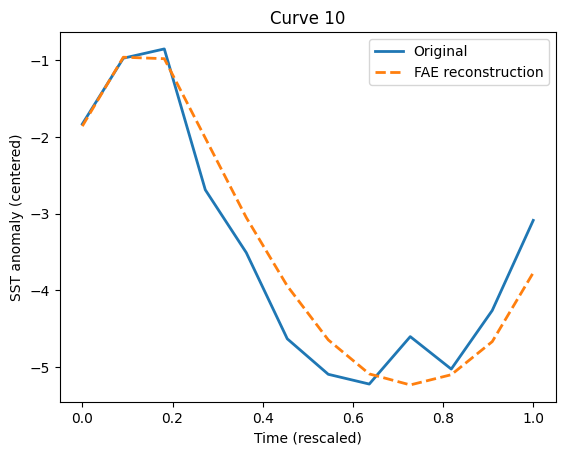

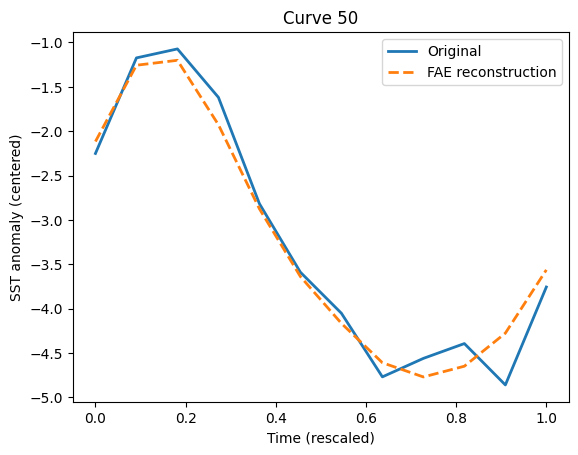

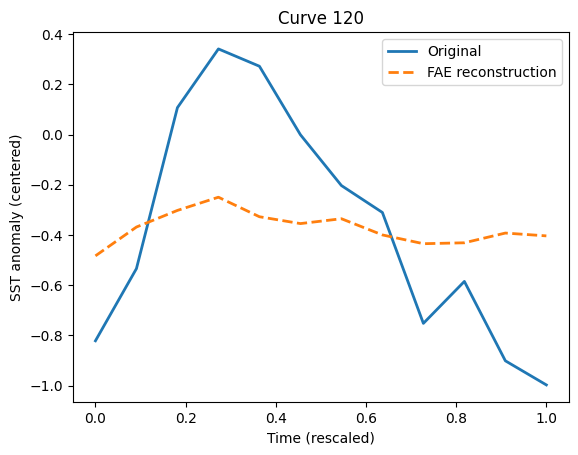

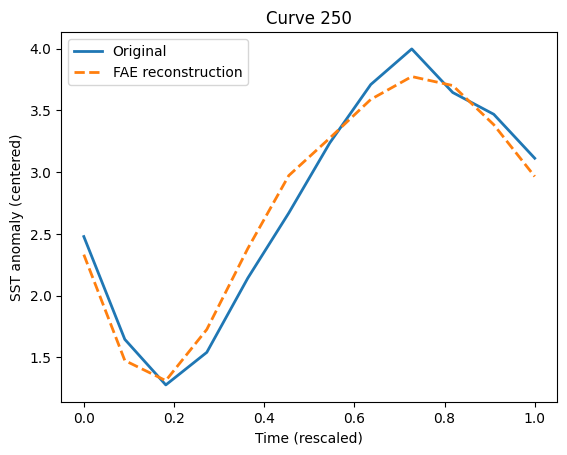

In [7]:
# Visualization
import matplotlib.pyplot as plt
import numpy as np
import torch

rep_idx = 0  # 0 = first replicate, it can be 0,...,4 (5 replicate)
FAE_pred_all = FAE_pred_all_niter[rep_idx]  

# time grid 
t = tpts.numpy().flatten() # 1D array for plotting

# choose some series indices to visualize
idx_list = [10, 50, 120, 250]

for idx in idx_list:
    orig = x[idx].detach().numpy()
    recon = FAE_pred_all[idx].detach().numpy()

    plt.figure()
    plt.plot(t, orig, label='Original', linewidth=2)
    plt.plot(t, recon, '--', label='FAE reconstruction', linewidth=2)
    plt.title(f'Curve {idx}')
    plt.xlabel('Time (rescaled)')
    plt.ylabel('SST anomaly (centered)')
    plt.legend()
    plt.show()


Loss / classification accuracy over epochs

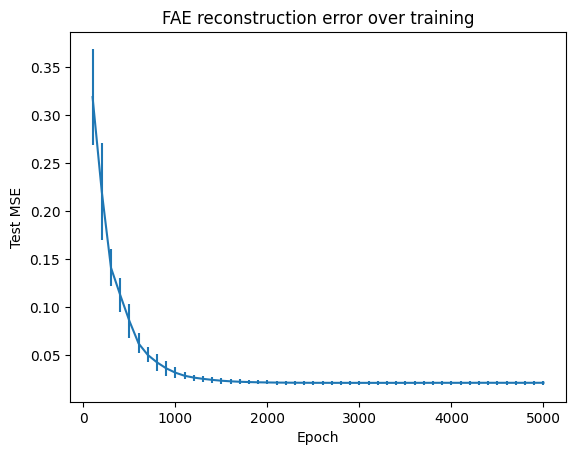

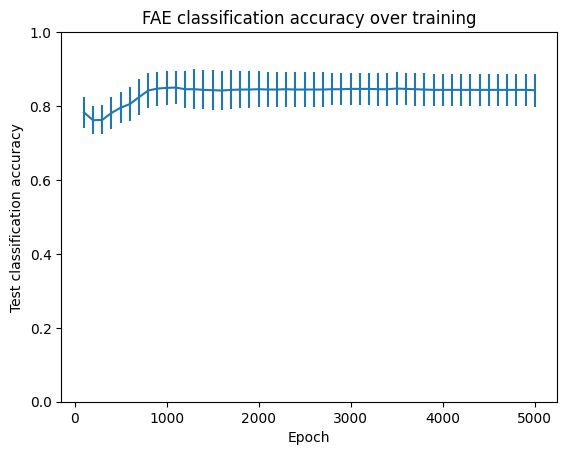

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# mean test MSE over replicates at each 100-epoch checkpoint
test_mse_mean = [np.mean(x) for x in FAE_reg_test_acc_epoch]
test_mse_sd   = [np.std(x)  for x in FAE_reg_test_acc_epoch]

# mean classification accuracy over replicates
test_acc_mean = [np.mean(x) for x in classification_FAE_reg_test_epoch]
test_acc_sd   = [np.std(x)  for x in classification_FAE_reg_test_epoch]

epochs_grid = np.arange(100, len(test_mse_mean)*100 + 1, 100)

plt.figure()
plt.errorbar(epochs_grid, test_mse_mean, yerr=test_mse_sd)
plt.xlabel('Epoch')
plt.ylabel('Test MSE')
plt.title('FAE reconstruction error over training')
plt.show()

plt.figure()
plt.errorbar(epochs_grid, test_acc_mean, yerr=test_acc_sd)
plt.xlabel('Epoch')
plt.ylabel('Test classification accuracy')
plt.ylim(0, 1)
plt.title('FAE classification accuracy over training')
plt.show()


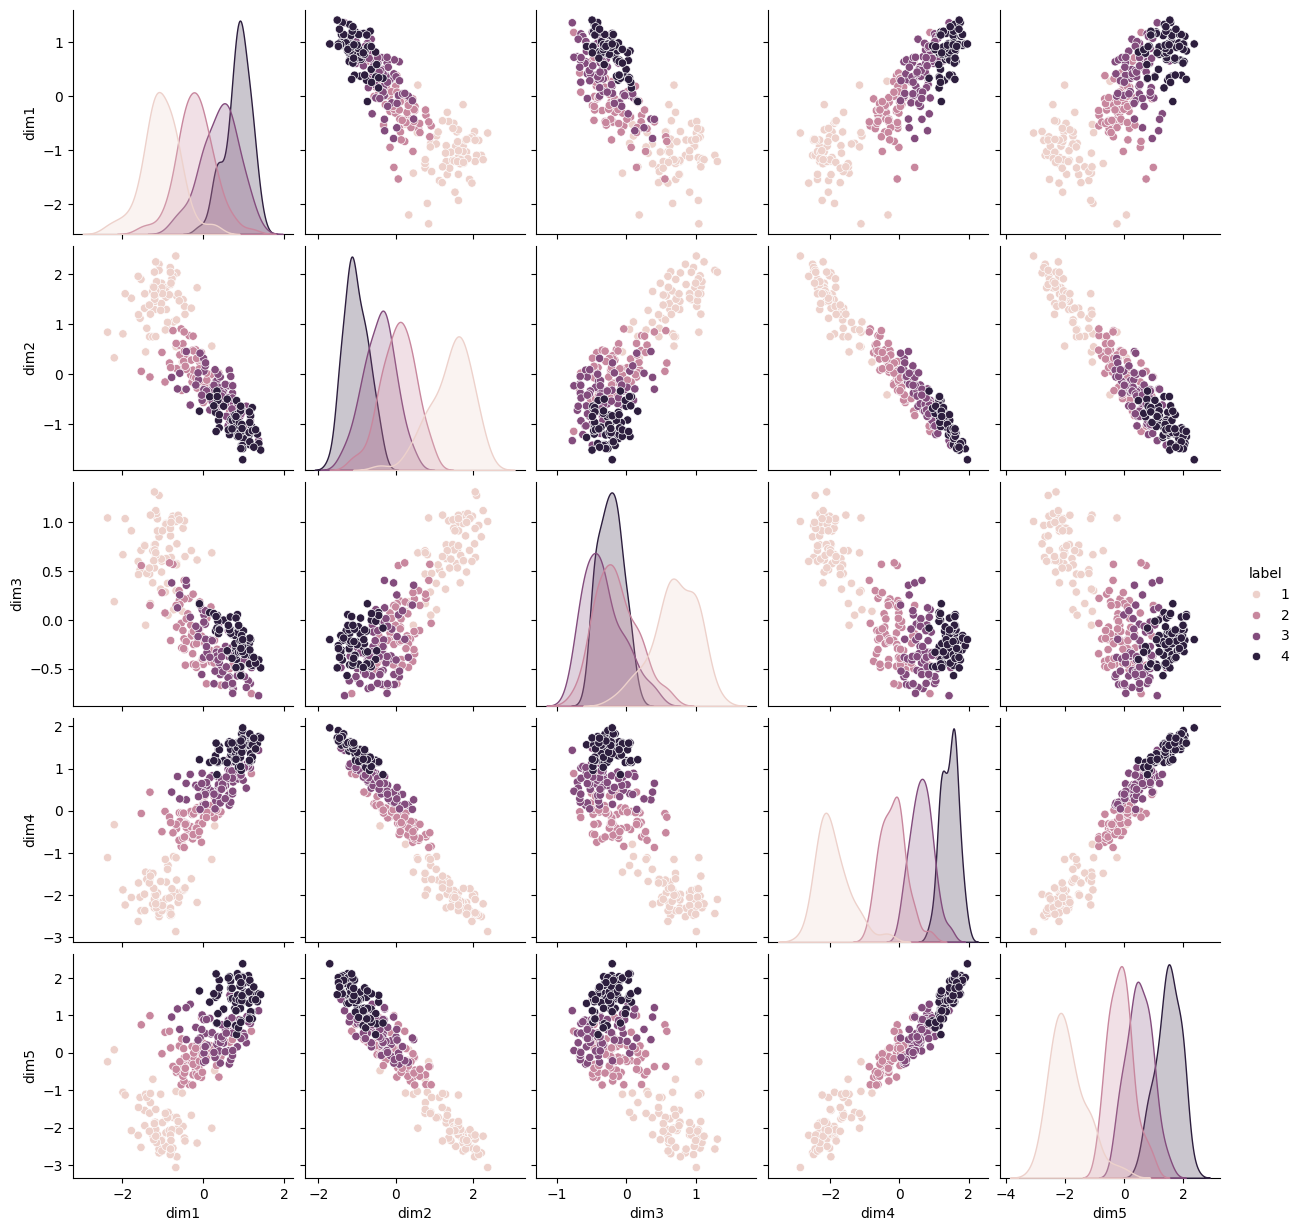

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

reps = FAE_reps_all_niter[0].detach().numpy()

df = pd.DataFrame(reps, columns=[f"dim{i+1}" for i in range(reps.shape[1])])
df["label"] = labels

sns.pairplot(df, hue="label")
plt.show()


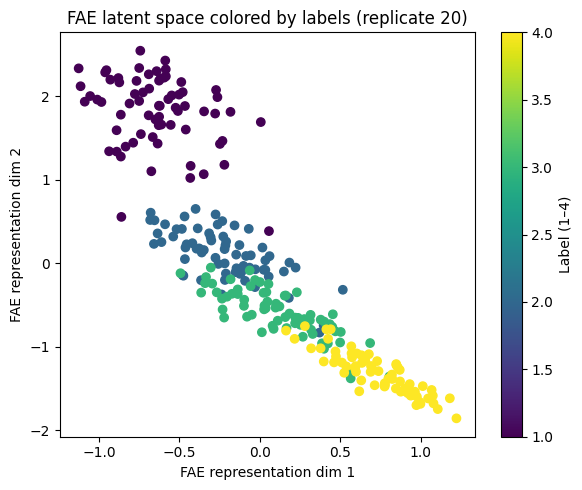

In [14]:
# After: FAE_pred_all, FAE_reps_all = pred(model, x)[0:2]
z = FAE_reps_all.detach().numpy()   # shape (277, n_rep)
lbl = label                         # from your CSV, shape (277,)

plt.figure(figsize=(6, 5))
scatter = plt.scatter(z[:, 0], z[:, 1], c=lbl, cmap='viridis')
plt.xlabel('FAE representation dim 1')
plt.ylabel('FAE representation dim 2')
plt.title(f'FAE latent space colored by labels (replicate {i+1})')
cbar = plt.colorbar(scatter)
cbar.set_label('Label (1–4)')
plt.tight_layout()
plt.show()



Confusion matrix (replicate 20):
[[13  1  0  0]
 [ 1 12  1  0]
 [ 0  1 10  3]
 [ 0  0  0 14]]


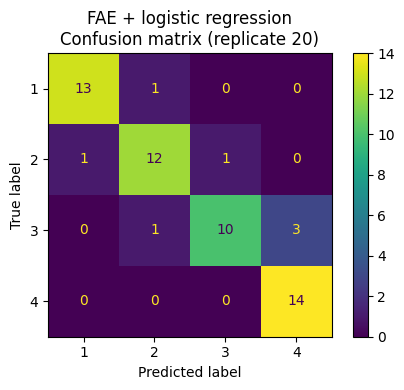

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict labels for the test set using your existing classifier
y_test_pred = FAE_classifier.predict(FAE_reps_test.detach().numpy())

# Confusion matrix: true (TestLabel) vs predicted (y_test_pred)
classes = [1, 2, 3, 4]
cm = confusion_matrix(TestLabel, y_test_pred, labels=classes)
print(f"\nConfusion matrix (replicate {i+1}):")
print(cm)

# Visualize confusion matrix
fig, ax = plt.subplots(figsize=(5, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(ax=ax)
ax.set_title(f'FAE + logistic regression\nConfusion matrix (replicate {i+1})')
plt.tight_layout()
plt.show()
